In [1]:
import os
import random
import numpy as np
from PIL import Image
import json
from collections import defaultdict
from sklearn.model_selection import train_test_split

import tensorflow as tf
# No need for ImageDataGenerator if we implement custom augmentation in Sequence

In [2]:
# --- 1. SET UP YOUR ENVIRONMENT AND PATHS ---
# This code assumes you have mounted your Google Drive in Colab
# and set up the folder structure as recommended.

# Path to the root of your project in Google Drive
# IMPORTANT: Make sure your Google Drive is mounted first!
from google.colab import drive
drive.mount('/content/drive')
project_root = '/content/drive/My Drive/ml_drone_project'

# Paths to your datasets
ROBOFLOW_THERMAL_PATH = os.path.join(project_root, 'datasets', 'roboflow_thermal_dogs_people')
HIT_UAV_PATH = os.path.join(project_root, 'datasets', 'hit_uav')
COCO_ANIMALS_PEOPLE_PATH = os.path.join(project_root, 'datasets', 'coco_animals_people')

# Define target image size for the model
TARGET_IMAGE_SIZE = (224, 224) # EfficientNetV2-M/L default input size
BATCH_SIZE = 32
RANDOM_SEED = 42

# Define class mappings
# Our final model will classify into 2 classes: Human (0) and Animal (1)
CLASS_MAP = {'human': 0, 'animal': 1}
REVERSE_CLASS_MAP = {0: 'human', 1: 'animal'}

# COCO category IDs for 'person' and various animals
# You can customize which animals you want to include from COCO
COCO_PERSON_ID = 1
COCO_ANIMAL_IDS = [
    15,  # bird
    16,  # cat
    17,  # dog
    18,  # horse
    19,  # sheep
    20,  # cow
    21,  # elephant
    22,  # bear
    23,  # zebra
    24   # giraffe
]
# Combine all relevant COCO IDs for filtering
COCO_TARGET_IDS = [COCO_PERSON_ID] + COCO_ANIMAL_IDS

Mounted at /content/drive


In [21]:
# --- 2. HELPER FUNCTIONS FOR IMAGE LOADING AND PREPROCESSING ---

def load_ir_image(image_path, target_size=TARGET_IMAGE_SIZE):
    """
    Loads a thermal image (typically 8-bit or 16-bit grayscale), resizes it,
    normalizes to [0, 1], and ensures 3 channels.
    """
    try:
        image = Image.open(image_path)
        image = image.resize(target_size, Image.Resampling.LANCZOS)
        image_array = np.array(image, dtype=np.float32)

        # Normalize
        if np.max(image_array) > 0:
            image_array = image_array / np.max(image_array)
        else:
            image_array = np.zeros_like(image_array)

        # Ensure 3 channels
        if image_array.ndim == 2:  # Grayscale
            image_array = np.stack([image_array] * 3, axis=-1)
        elif image_array.ndim == 3 and image_array.shape[2] == 1:  # (H, W, 1)
            image_array = np.repeat(image_array, 3, axis=-1)
        elif image_array.ndim == 3 and image_array.shape[2] == 3:
            pass  # Already valid
        else:
            print(f"Unexpected IR image shape after loading: {image_array.shape}")
            return None

        return image_array

    except Exception as e:
        print(f"Error loading IR image {image_path}: {e}")
        return None

def load_rgb_image(image_path, target_size=TARGET_IMAGE_SIZE):
    """
    Loads a standard RGB image, resizes it, and normalizes it to [0, 1].
    """
    try:
        image = Image.open(image_path).convert('RGB') # Ensure 3 channels
        image = image.resize(target_size, Image.Resampling.LANCZOS)
        image_array = np.array(image, dtype=np.float32)

        # Normalize RGB images to 0-1 range
        image_array = image_array / 255.0

        return image_array

    except Exception as e:
        print(f"Error loading RGB image {image_path}: {e}")
        return None

In [22]:
# --- 3. ANNOTATION PARSING FUNCTIONS ---

def parse_roboflow_annotations(annotations_file_path):
    """
    Parses Roboflow-style JSON annotation file and returns image paths and labels.
    Assumes images are in the same directory as the JSON.
    """
    image_info_list = []

    try:
        # Check if annotation file exists
        if not os.path.exists(annotations_file_path):
            print(f"Warning: Annotation file {annotations_file_path} does not exist")
            return image_info_list

        with open(annotations_file_path, 'r') as f:
            data = json.load(f)

        # Debug: Print the structure of the JSON
        print(f"Parsing {annotations_file_path}")
        print(f"JSON keys: {list(data.keys())}")

        if 'categories' in data:
            print(f"Categories: {[(cat['id'], cat['name']) for cat in data['categories']]}")

        if 'images' in data:
            print(f"Total images in annotation: {len(data['images'])}")

        if 'annotations' in data:
            print(f"Total annotations: {len(data['annotations'])}")

        # We need to get the parent directory for image loading
        base_dir = os.path.dirname(annotations_file_path)
        print(f"Looking for images in: {base_dir}")

        # Check what files actually exist in the directory
        if os.path.exists(base_dir):
            actual_files = [f for f in os.listdir(base_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            print(f"Actual image files found: {len(actual_files)}")
            if len(actual_files) > 0:
                print(f"Sample files: {actual_files[:5]}")

        # Create mapping from image_id to file_name
        if 'images' not in data:
            print("Error: No 'images' key in JSON data")
            return image_info_list

        image_id_to_filename = {img['id']: img['file_name'] for img in data['images']}

        # Track processed images to avoid duplicates
        processed_images = set()

        for ann in data['annotations']:
            image_id = ann['image_id']
            category_id = ann['category_id']

            # Skip if we've already processed this image
            if image_id in processed_images:
                continue

            # Map category_id to category name
            category_name = None
            for cat in data['categories']:
                if cat['id'] == category_id:
                    category_name = cat['name'].lower()
                    break

            if not category_name:
                continue

            # Map to our classes
            label = None
            if category_name in ['person', 'people', 'human']:
                label = CLASS_MAP['human']
            elif category_name in ['dog', 'animal']:
                label = CLASS_MAP['animal']
            else:
                print(f"Skipping unknown category: {category_name}")
                continue

            image_filename = image_id_to_filename.get(image_id)
            if not image_filename:
                continue

            image_path = os.path.join(base_dir, image_filename)

            # CHECK IF FILE EXISTS BEFORE ADDING
            if not os.path.exists(image_path):
                print(f"Warning: Image file {image_filename} not found at {image_path}")
                continue

            image_info_list.append({'path': image_path, 'label': label})
            processed_images.add(image_id)

        print(f"Successfully parsed {len(image_info_list)} images from {annotations_file_path}")

    except Exception as e:
        print(f"Error parsing Roboflow annotations {annotations_file_path}: {e}")
        import traceback
        traceback.print_exc()

    return image_info_list

def parse_hit_uav_labels(labels_dir_path):
    """
    Parses HIT-UAV YOLO-style TXT labels and returns image paths and labels.
    Assumes image files are in a sibling 'images' directory.
    """
    image_info_list = []

    # Assuming YOLO format: one .txt file per image, containing class_id x_center y_center width height
    # And images are in a parallel 'images' directory.

    image_base_dir = os.path.join(os.path.dirname(os.path.dirname(labels_dir_path)), 'images', os.path.basename(labels_dir_path))

    for label_file in os.listdir(labels_dir_path):
        if label_file.endswith('.txt'):
            label_path = os.path.join(labels_dir_path, label_file)
            image_filename = label_file.replace('.txt', '.jpg') # Assuming .jpg images
            image_path = os.path.join(image_base_dir, image_filename)

            if not os.path.exists(image_path):
                print(f"Warning: Image {image_path} not found for label {label_file}. Skipping.")
                continue

            with open(label_path, 'r') as f:
                lines = f.readlines()

            # HIT-UAV has 'Person', 'Car', 'Bicycle', 'OtherVehicle', 'DontCare'
            # You need to know the mapping of their class IDs to names.
            # Assuming 'Person' is class ID 0 in their YOLO format.
            found_person = False
            for line in lines:
                parts = line.strip().split()
                if len(parts) > 0:
                    class_id = int(parts[0])
                    # Assuming HIT-UAV 'Person' class ID is 0
                    if class_id == 0: # This is the 'Person' class in HIT-UAV
                        found_person = True
                        break

            if found_person:
                image_info_list.append({'path': image_path, 'label': CLASS_MAP['human']})
            # HIT-UAV does not have animal classes. We only extract 'human' here.

    return image_info_list

def parse_coco_annotations(annotations_file_path, images_base_dir):
    """
    Parses COCO-style JSON annotation file, filters for 'person' and animal classes,
    and returns image paths and labels.
    """
    image_info_list = []

    try:
        with open(annotations_file_path, 'r') as f:
            data = json.load(f)

        # Create a mapping from category ID to category name
        category_id_to_name = {cat['id']: cat['name'] for cat in data['categories']}

        # Create a mapping from image ID to image file name
        image_id_to_filename = {img['id']: img['file_name'] for img in data['images']}

        # Store images by their dominant class (human or animal)
        # An image can contain multiple objects. We prioritize 'human' if present.
        coco_human_images = []
        coco_animal_images = []

        # Track which images have already been processed to avoid duplicates
        processed_image_ids = set()

        for ann in data['annotations']:
            image_id = ann['image_id']
            category_id = ann['category_id']

            if image_id in processed_image_ids:
                continue # Already processed this image for its dominant class

            image_filename = image_id_to_filename.get(image_id)
            if not image_filename:
                continue # Skip if image file name not found

            image_path = os.path.join(images_base_dir, image_filename)
            # CHECK IF FILE EXISTS BEFORE ADDING
            if not os.path.exists(image_path):
                continue  # Skip if image file doesn't exist

            if category_id == COCO_PERSON_ID:
                coco_human_images.append({'path': image_path, 'label': CLASS_MAP['human']})
                processed_image_ids.add(image_id) # Mark as processed for dominant class
            elif category_id in COCO_ANIMAL_IDS:
                coco_animal_images.append({'path': image_path, 'label': CLASS_MAP['animal']})
                processed_image_ids.add(image_id) # Mark as processed for dominant class

    except Exception as e:
        print(f"Error parsing COCO annotations {annotations_file_path}: {e}")

    return coco_human_images, coco_animal_images

In [23]:
# --- 4. THE CUSTOM DATA GENERATOR CLASS ---

class MultiModalDataGenerator(tf.keras.utils.Sequence):
    """
    A custom data generator for our multi-modal model.
    It handles loading both IR and RGB images for a given batch,
    and applies consistent data augmentation.
    """
    def __init__(self,
                 ir_data_info, # List of {'path': ..., 'label': ...} for IR images
                 rgb_human_paths, # List of RGB image paths for human class
                 rgb_animal_paths, # List of RGB image paths for animal class
                 batch_size=BATCH_SIZE,
                 target_size=TARGET_IMAGE_SIZE,
                 shuffle=True,
                 seed=RANDOM_SEED,
                 horizontal_flip_prob=0.5
                 ):

        self.ir_data_info = ir_data_info
        self.rgb_human_paths = rgb_human_paths
        self.rgb_animal_paths = rgb_animal_paths
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.seed = seed

        self.horizontal_flip_prob = horizontal_flip_prob

        self.on_epoch_end() # Initialize indices

    def __len__(self):
        """Returns the number of batches per epoch."""
        return int(np.floor(len(self.ir_data_info) / self.batch_size))

    def __getitem__(self, index):
        """Generates one batch of data."""
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        ir_batch_data_info = [self.ir_data_info[k] for k in batch_indices]

        X, y = self.__data_generation(ir_batch_data_info)
        return X, y

    def on_epoch_end(self):
        """Updates indices for shuffling after each epoch."""
        self.indices = np.arange(len(self.ir_data_info))
        if self.shuffle:
            np.random.seed(self.seed)
            np.random.shuffle(self.indices)

    def __data_generation(self, ir_batch_data_info):
        """
        Loads, processes, and augments a batch of images.
        Dynamically pairs IR images with relevant RGB images.
        """
        batch_rgb = []
        batch_ir = []
        batch_labels = []

        for item in ir_batch_data_info:
            # --- FIX 1: Add a check for malformed data ---
            # This prevents the initial TypeError you encountered.
            if not isinstance(item, dict) or 'path' not in item or 'label' not in item:
                print(f"Warning: Skipping malformed item in data generator: {item}")
                continue

            ir_path = item['path']
            ir_label = item['label']

            # Load IR image
            ir_image = load_ir_image(ir_path, self.target_size)
            if ir_image is None:
                continue # Skip if IR image loading failed

            # Select a corresponding RGB image based on the IR image's label
            rgb_path = None
            if ir_label == CLASS_MAP['human'] and self.rgb_human_paths:
                # --- FIX 2: Correctly select the RGB path string ---
                # `self.rgb_human_paths` is a list of strings, so `random.choice` returns the string itself.
                # The old code `random.choice(...)[path]` would cause a TypeError.
                rgb_path = random.choice(self.rgb_human_paths)
            elif ir_label == CLASS_MAP['animal'] and self.rgb_animal_paths:
                # --- FIX 2 (continued): Correctly select the RGB path string ---
                rgb_path = random.choice(self.rgb_animal_paths)

            # Load RGB image (or use a black placeholder if no suitable RGB image found)
            rgb_image = load_rgb_image(rgb_path, self.target_size) if rgb_path else \
                        np.zeros((*self.target_size, 3), dtype=np.float32)

            if rgb_image is None:
                continue

            # --- Shape validation ---
            if ir_image.shape != (224, 224, 3):
              print(f"Invalid IR image shape {ir_image.shape} at: {ir_path}")
              continue
            if rgb_image.shape != (224, 224, 3):
              print(f"Invalid RGB image shape {rgb_image.shape} at: {rgb_path}")
              continue

            # --- Apply Consistent Data Augmentation ---
            random_state = np.random.RandomState(np.random.randint(0, 2**32 - 1))

            if random_state.rand() < self.horizontal_flip_prob:
                ir_image = np.fliplr(ir_image)
                rgb_image = np.fliplr(rgb_image)

            batch_ir.append(ir_image)
            batch_rgb.append(rgb_image)
            batch_labels.append(ir_label)

        # Convert to numpy arrays
        X_ir = np.array(batch_ir)
        X_rgb = np.array(batch_rgb)
        y = np.array(batch_labels)

        # Return a dictionary of inputs for our multi-input Keras model
        return {'ir_input': X_ir, 'rgb_input': X_rgb}, y

In [24]:
# --- 5. DATASET PREPARATION AND GENERATOR INSTANTIATION ---

def get_all_dataset_info(project_root_path):
    """
    Orchestrates parsing all datasets and preparing data info lists.
    """
    print("--- Parsing Roboflow Thermal Dogs and People Dataset ---")
    roboflow_train_ann_file = os.path.join(ROBOFLOW_THERMAL_PATH, 'train', '_annotations.coco.json')
    roboflow_val_ann_file = os.path.join(ROBOFLOW_THERMAL_PATH, 'valid', '_annotations.coco.json')
    roboflow_test_ann_file = os.path.join(ROBOFLOW_THERMAL_PATH, 'test', '_annotations.coco.json')

    roboflow_train_info = parse_roboflow_annotations(roboflow_train_ann_file)
    roboflow_val_info = parse_roboflow_annotations(roboflow_val_ann_file)
    roboflow_test_info = parse_roboflow_annotations(roboflow_test_ann_file)
    print(f"Roboflow Thermal Train: {len(roboflow_train_info)} images")
    print(f"Roboflow Thermal Val: {len(roboflow_val_info)} images")
    print(f"Roboflow Thermal Test: {len(roboflow_test_info)} images")

    print("\n--- Parsing HIT-UAV Dataset ---")
    hit_uav_train_labels_dir = os.path.join(HIT_UAV_PATH, 'labels', 'train')
    hit_uav_val_labels_dir = os.path.join(HIT_UAV_PATH, 'labels', 'val')
    hit_uav_test_labels_dir = os.path.join(HIT_UAV_PATH, 'labels', 'test')

    hit_uav_train_info = parse_hit_uav_labels(hit_uav_train_labels_dir)
    hit_uav_val_info = parse_hit_uav_labels(hit_uav_val_labels_dir)
    hit_uav_test_info = parse_hit_uav_labels(hit_uav_test_labels_dir)
    print(f"HIT-UAV Train (Humans only): {len(hit_uav_train_info)} images")
    print(f"HIT-UAV Val (Humans only): {len(hit_uav_val_info)} images")
    print(f"HIT-UAV Test (Humans only): {len(hit_uav_test_info)} images")

    print("\n--- Parsing COCO Animals/People Dataset ---")
    # Corrected COCO image directory paths to remove '2017'
    coco_train_ann_file = os.path.join(COCO_ANIMALS_PEOPLE_PATH, 'annotations', 'instances_train.json')
    coco_val_ann_file = os.path.join(COCO_ANIMALS_PEOPLE_PATH, 'annotations', 'instances_val.json')

    coco_train_images_dir = os.path.join(COCO_ANIMALS_PEOPLE_PATH, 'train')
    coco_val_images_dir = os.path.join(COCO_ANIMALS_PEOPLE_PATH, 'val')

    coco_train_humans, coco_train_animals = parse_coco_annotations(coco_train_ann_file, coco_train_images_dir)
    coco_val_humans, coco_val_animals = parse_coco_annotations(coco_val_ann_file, coco_val_images_dir)

    all_coco_humans = coco_train_humans + coco_val_humans
    all_coco_animals = coco_train_animals + coco_val_animals

    human_train_val, human_test = train_test_split(all_coco_humans, test_size=0.1, random_state=RANDOM_SEED)
    human_train, human_val = train_test_split(human_train_val, test_size=0.111, random_state=RANDOM_SEED)

    animal_train_val, animal_test = train_test_split(all_coco_animals, test_size=0.1, random_state=RANDOM_SEED)
    animal_train, animal_val = train_test_split(animal_train_val, test_size=0.111, random_state=RANDOM_SEED)

    print(f"COCO Train (new): {len(human_train)} humans, {len(animal_train)} animals")
    print(f"COCO Val (new): {len(human_val)} humans, {len(animal_val)} animals")
    print(f"COCO Test (new): {len(human_test)} humans, {len(animal_test)} animals")

    all_ir_train_info = roboflow_train_info + hit_uav_train_info
    all_ir_val_info = roboflow_val_info + hit_uav_val_info
    all_ir_test_info = roboflow_test_info + hit_uav_test_info

    all_rgb_human_paths = [item['path'] for item in human_train + human_val + human_test]
    all_rgb_animal_paths = [item['path'] for item in animal_train + animal_val + animal_test]

    random.seed(RANDOM_SEED)
    random.shuffle(all_rgb_human_paths)
    random.shuffle(all_rgb_animal_paths)

    print(f"\nTotal IR (Train+Val+Test) images: {len(all_ir_train_info) + len(all_ir_val_info) + len(all_ir_test_info)}")
    print(f"Total RGB Human images available for pairing: {len(all_rgb_human_paths)}")
    print(f"Total RGB Animal images available for pairing: {len(all_rgb_animal_paths)}")

    train_generator = MultiModalDataGenerator(
        ir_data_info=all_ir_train_info,
        rgb_human_paths=all_rgb_human_paths,
        rgb_animal_paths=all_rgb_animal_paths,
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    validation_generator = MultiModalDataGenerator(
        ir_data_info=all_ir_val_info,
        rgb_human_paths=all_rgb_human_paths,
        rgb_animal_paths=all_rgb_animal_paths,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    test_generator = MultiModalDataGenerator(
        ir_data_info=all_ir_test_info,
        rgb_human_paths=all_rgb_human_paths,
        rgb_animal_paths=all_rgb_animal_paths,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting data preprocessing...
--- Parsing Roboflow Thermal Dogs and People Dataset ---
Parsing /content/drive/My Drive/ml_drone_project/datasets/roboflow_thermal_dogs_people/train/_annotations.coco.json
JSON keys: ['info', 'licenses', 'categories', 'images', 'annotations']
Categories: [(0, 'dogs-person'), (1, 'dog'), (2, 'person')]
Total images in annotation: 142
Total annotations: 181
Looking for images in: /content/drive/My Drive/ml_drone_project/datasets/roboflow_thermal_dogs_people/train
Actual image files found: 142
Sample files: ['IMG_0006 4_jpg.rf.c99fb087ed0232d9d84e6e641c6571a2.jpg', 'IMG_0007 4_jpg.rf.311f81c92ebb559c27a202eb9f31f573.jpg', 'IMG_0007 5_jpg.rf.b6cc103cc795e75cf124dc75dbdcccc0.jpg', 'IMG_0007_jpg.rf.7b565936f19c31ddf7caba52158428da.jpg', 'IMG_0007 3_jpg.rf.e838060bfb5fba115ee350d6637ae440.jpg']
Successfully parsed 131 images from /con

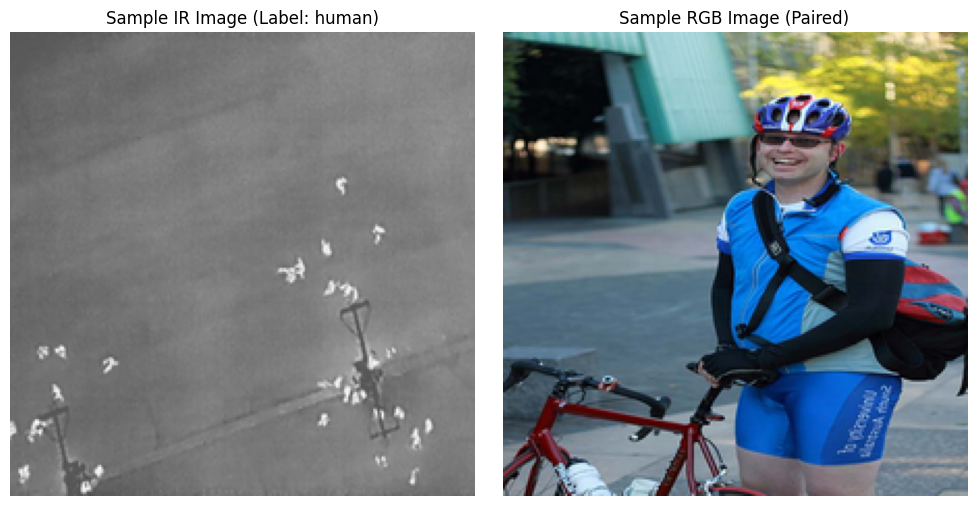


Data preprocessing complete. Generators are ready for model training.


In [25]:
# --- 6. MAIN EXECUTION BLOCK ---

if __name__ == '__main__':
    # Mount Google Drive (this cell should be run first in Colab)
    from google.colab import drive
    drive.mount('/content/drive')

    print("Starting data preprocessing...")
    train_gen, val_gen, test_gen = get_all_dataset_info(project_root)

    print("\n--- Data Generators Created ---")
    print(f"Training batches: {len(train_gen)}")
    print(f"Validation batches: {len(val_gen)}")
    print(f"Test batches: {len(test_gen)}")

    # --- Verify a sample batch ---
    print("\nVerifying a sample batch from training generator...")
    try:
        sample_inputs, sample_labels = train_gen[0] # Get the first batch

        ir_sample_batch = sample_inputs['ir_input']
        rgb_sample_batch = sample_inputs['rgb_input']
        labels_sample_batch = sample_labels

        print(f"IR Batch Shape: {ir_sample_batch.shape}")
        print(f"RGB Batch Shape: {rgb_sample_batch.shape}")
        print(f"Labels Batch Shape: {labels_sample_batch.shape}")
        print(f"Sample Labels (first 5): {labels_sample_batch[:5]}")
        print(f"Sample Labels (first 5, mapped): {[REVERSE_CLASS_MAP[l] for l in labels_sample_batch[:5]]}")

        # Optional: Visualize a sample image pair
        import matplotlib.pyplot as plt

        plt.figure(figsize=(10, 5))

        # Display IR image
        plt.subplot(1, 2, 1)
        # For IR, if it was originally grayscale, you might want to use a colormap
        # If it's 3-channel stacked grayscale, matplotlib will display it as grayscale.
        plt.imshow(ir_sample_batch[0])
        plt.title(f"Sample IR Image (Label: {REVERSE_CLASS_MAP[labels_sample_batch[0]]})")
        plt.axis('off')

        # Display RGB image
        plt.subplot(1, 2, 2)
        plt.imshow(rgb_sample_batch[0])
        plt.title(f"Sample RGB Image (Paired)")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error verifying sample batch: {e}")
        print("Please ensure your dataset paths are correct and data exists in the specified structure.")

    print("\nData preprocessing complete. Generators are ready for model training.")